In [1]:
import os, json
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme()

In [3]:
# Load PO-UCT results
data_path = "./data/simulation_results/pouct_eval/"
file_names = [f for f in os.listdir(data_path) if f.endswith('.csv')]

data = []
for file_name in file_names:
    data.append(pd.read_csv(data_path+file_name))


pouct_data = pd.concat(data)
pouct_data["type"] = "PO-UCT: " + pouct_data["steps"].astype(str)
pouct_data.head()


,Unnamed: 0,reward,actions,seed,runtime,true_reward,expected_reward,steps,exploration_coeff,rollout_depth,type
0,0,3.732784,5,5000,1.707762,4.035003,3.732784,1000,10.0,0,PO-UCT: 1000
1,1,3.642689,5,5001,1.815193,4.204752,3.642689,1000,10.0,0,PO-UCT: 1000
2,2,3.707361,5,5002,1.933776,4.891583,3.707361,1000,10.0,0,PO-UCT: 1000
3,3,3.758194,5,5003,2.119002,5.131884,3.758194,1000,10.0,0,PO-UCT: 1000
4,4,3.922327,5,5004,2.121899,4.297647,3.922327,1000,10.0,0,PO-UCT: 1000


In [4]:
project_data = pd.read_csv("./data/simulation_results/eval_voc.csv")
project_data["type"] = "Ours"
project_data["steps"] = 10000
project_data.head()

,Unnamed: 0,reward,actions,seed,runtime,true_reward,expected_reward,type,steps
0,0,3.821586,3,5000,0.765625,4.039003,3.821586,Ours,10000
1,1,3.819586,4,5001,0.890625,3.173295,3.819586,Ours,10000
2,2,3.716219,5,5002,0.875000,4.638325,3.716219,Ours,10000
3,3,3.821586,3,5003,0.718750,5.135884,3.821586,Ours,10000
4,4,3.658340,5,5004,0.890625,4.297647,3.658340,Ours,10000


In [5]:
merge_col = ["type", "expected_reward", "true_reward", "actions", "runtime"]
temp1 = project_data[merge_col]
temp2 = pouct_data[merge_col]

df = pd.concat([temp1, temp2])
df.dtypes


type                object
expected_reward    float64
true_reward        float64
actions              int64
runtime            float64
steps                int64
dtype: object

Text(0.5, 0, '')

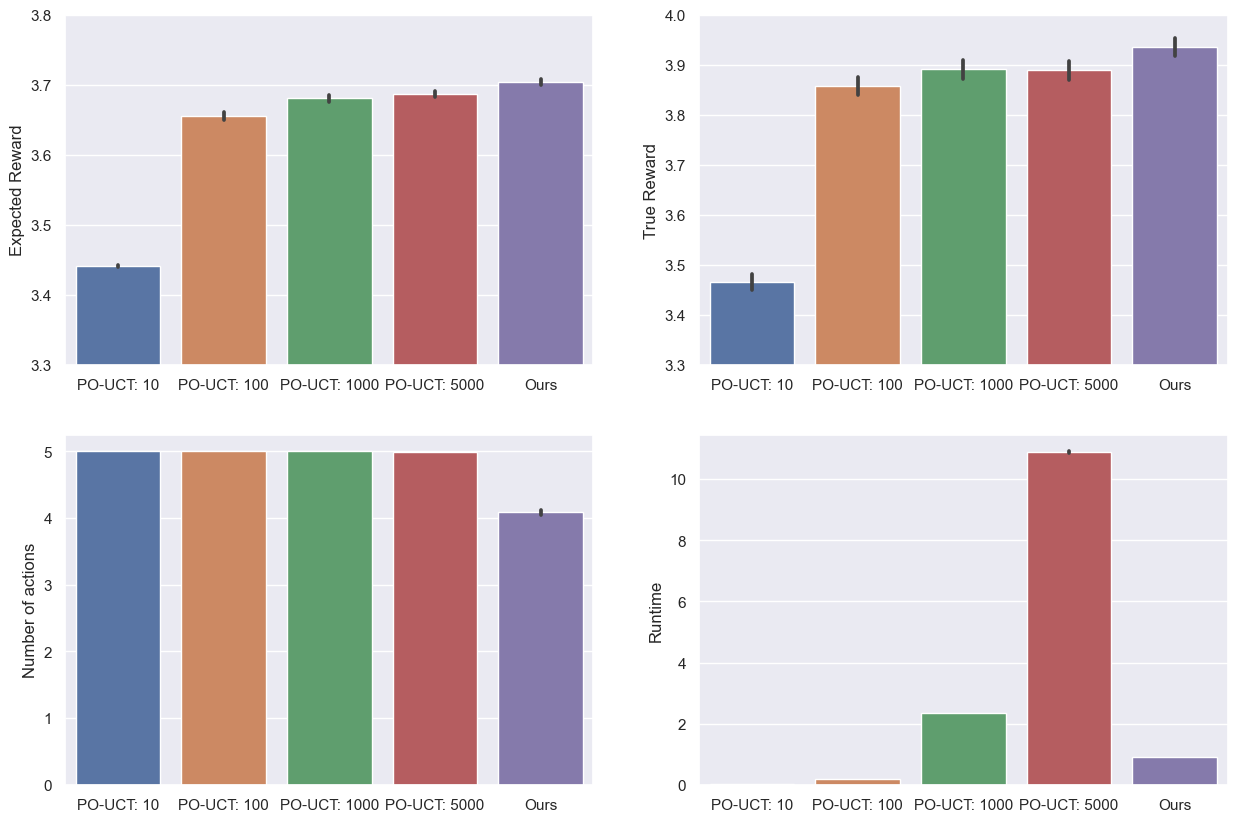

In [8]:
order = ["PO-UCT: 10", "PO-UCT: 100", "PO-UCT: 1000", "PO-UCT: 5000", "Ours"]

fig, axes =plt.subplots(2,2, figsize=(15,10))
axes = axes.flatten()

g = sns.barplot(df, y="expected_reward", x="type", ax=axes[0], order=order)
g.set_ylim((3.3, 3.8))
g.set_ylabel("Expected Reward")
g.set_xlabel("")
g = sns.barplot(df, y="true_reward", x="type", ax=axes[1], order=order)
g.set_ylim((3.3, 4))
g.set_ylabel("True Reward")
g.set_xlabel("")
g = sns.barplot(df, y="actions", x="type", ax=axes[2], order=order)
g.set_ylabel("Number of actions")
g.set_xlabel("")
g = sns.barplot(df, y="runtime", x="type", ax=axes[3], order=order)
g.set_ylabel("Runtime")
g.set_xlabel("")

In [9]:
df.groupby("type").agg(["mean", "std"])[["expected_reward", "true_reward", "actions", "runtime"]]

expected_reward           true_reward           actions  \
                        mean       std        mean       std    mean   
type                                                                   
Ours                3.703654  0.154958    3.935251  0.669471  4.0886   
PO-UCT: 10          3.441149  0.070251    3.466526  0.587431  5.0000   
PO-UCT: 100         3.655282  0.200118    3.857554  0.669389  5.0000   
PO-UCT: 1000        3.680492  0.169651    3.891671  0.672936  5.0000   
PO-UCT: 5000        3.687342  0.153507    3.888619  0.673060  4.9968   

                          runtime            
                   std       mean       std  
type                                         
Ours          1.212041   0.907903  0.188577  
PO-UCT: 10    0.000000   0.017456  0.013537  
PO-UCT: 100   0.000000   0.197186  0.028455  
PO-UCT: 1000  0.000000   2.356704  0.101320  
PO-UCT: 5000  0.072047  10.891260  0.624029

In [10]:
df.to_csv("./data/simulation_results/simulation_data.csv")